<a href="https://colab.research.google.com/github/jyotidabass/Idea-to-image-generation-with-stable-diffusion/blob/main/Idea_to_image_generation_with_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is based on https://github.com/huggingface/diffusers


In [1]:
!pip install --upgrade diffusers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.9 MB/s eta 0:00:00


In [2]:
!conda install -c conda-forge diffusers

/bin/bash: line 1: conda: command not found


In [3]:
!nvidia-smi

Wed Nov 29 16:44:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

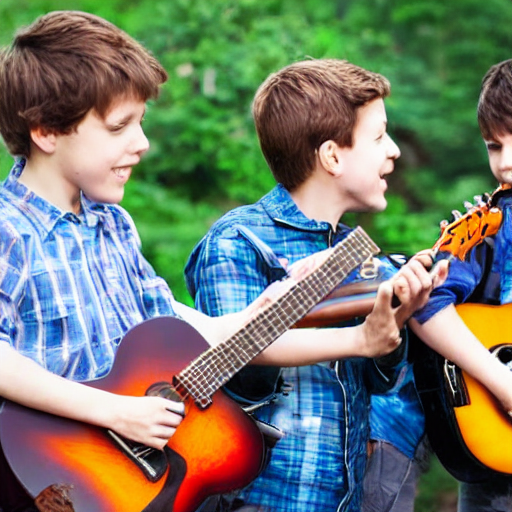

In [7]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipeline.to("cuda")
pipeline("Four boys are playing guitar on road").images[0]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

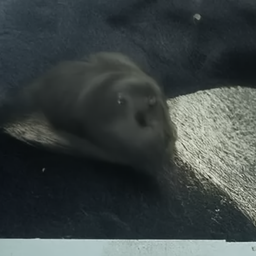

In [5]:
from diffusers import DDPMScheduler, UNet2DModel
from PIL import Image
import torch

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")
scheduler.set_timesteps(50)

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
        prev_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
        input = prev_noisy_sample

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image